In [ ]:
# Questions

What happens to the experience of contacting and booking a place on Airbnb when the guest is required to write a message like this?

What should we do with change, expand to all or cancel?

How would you explain the results to someone who is not highly technical?

# Plan
Import data
Exploratory
Any cleanup?
Evaluate - bootstrap
but what else happened to the experience?
Recommendations

Keep the top level plan in mind. And, you have finite energy!

+ video
+ models

In [ ]:
# Notes
# build models?

# precision of experiment?
# the totals line up, which is nice

# brush up on what this is exactly saying, but for now
# Given observations
# take the total assignments in each group
# calculate the expected ratio for each month
# see if there's a large divergence

# these are guest ATTEMPTS, remember

# Did people write at the same rate?
# message length
# were they replied/accepted/booked at the same rate?
# bootstrap this

# is there even a relationship between message length and all these?

# rates, seasonality, all that?

# but more statistical tests would be nice
# also f seaborn, maybe we can do a line fill

#4-6 hours huh


# examine by month as well?
# any time series trends?


In [98]:
import pandas as pd
from scipy.stats import chi2_contingency, chisquare

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display, HTML

%matplotlib inline

### Data

In [258]:
# import
assignments = pd.read_csv('Airbnb/takehome_assignments.csv')
print assignments.shape
contacts = pd.read_csv('Airbnb/takehome_contacts.csv')
print contacts.shape

# clean
# take out users assigned to multiple groups
assignments = assignments.groupby('id_user').filter(lambda x: x['ab'].nunique() == 1)
# remove duplicate assignments
assignments = assignments.groupby(['id_user', 'ab']).agg('count').reset_index()

# merge
data = contacts.merge(assignments, left_on='id_guest', right_on='id_user')
print data.shape

# transform
data['ts_interaction_first'] = pd.to_datetime(data['ts_interaction_first'])
data = pd.concat([data, pd.get_dummies(data['ab'])], axis=1)
data['ts_interaction_first_month'] = data['ts_interaction_first'].apply(lambda x: '{}-{:02}'.format(x.year, x.month))

# subsets
all_data = data
idx = data['dim_contact_channel'] == 'contact_me'
contact_data = all_data[idx]

# any data validation here?

(10000, 2)
(10000, 9)
(9104, 11)


### Data overview

In [259]:
# Guest attempts per channel
pd.pivot_table(all_data, 
               values='id_guest', 
               index='ts_interaction_first_month', 
               columns='dim_contact_channel', 
               aggfunc='count').fillna(0)

dim_contact_channel,book_it,contact_me,instant_booked
ts_interaction_first_month,,,
2013-01,83,450,1
2013-02,81,497,4
2013-03,95,670,1
2013-04,119,772,5
2013-05,136,840,0
2013-06,135,755,2
2013-07,207,755,3
2013-08,251,715,8
2013-09,228,585,2


In [260]:
# Guest outcomes
all_data.set_index('ts_interaction_first').resample('M', {'id_guest':'count',
                                                          'ts_reply_at_first':'count',
                                                          'ts_accepted_at_first':'count',
                                                          'ts_booking_at':'count'})

,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,id_guest
ts_interaction_first,,,,
2013-01-31,476,204,130,534
2013-02-28,509,203,124,582
2013-03-31,678,262,178,766
2013-04-30,744,275,172,896
2013-05-31,811,289,191,976
2013-06-30,731,272,168,892
2013-07-31,815,322,213,965
2013-08-31,833,349,240,974
2013-09-30,717,297,199,815


### Was the experiment done correctly?

In [261]:
# Were the control/treatment allocations skewed in any way? 
# (I looked at this by channel too, for some reason)
# (control and treatment added up to totals)

how = {'control':'sum', 'treatment':'sum'}
monthly = all_data.set_index('ts_interaction_first').resample('M', how=how)
chi2_contingency(monthly)

(8.4900358591822354,
 0.66885022936276195,
 11,
 array([[ 266.88268893,  267.11731107],
        [ 290.87214411,  291.12785589],
        [ 382.83172232,  383.16827768],
        [ 447.80316344,  448.19683656],
        [ 487.78558875,  488.21441125],
        [ 445.80404218,  446.19595782],
        [ 482.28800527,  482.71199473],
        [ 486.78602812,  487.21397188],
        [ 407.32095782,  407.67904218],
        [ 308.8642355 ,  309.1357645 ],
        [ 267.88224956,  268.11775044],
        [ 274.87917399,  275.12082601]]))

In [265]:
contact_data.loc[control_idx, 'm_first_message_length'].describe()

count    3648.000000
mean      343.475603
std       238.579193
min         0.000000
25%       186.000000
50%       289.000000
75%       435.250000
max      2654.000000
Name: m_first_message_length, dtype: float64

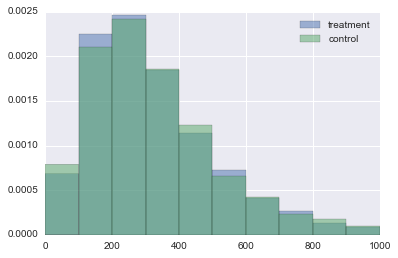

In [280]:
# What happened to message length? 
# Expect to see no first messages < 140

control_idx = contact_data['ab'] == 'control'
treatment_idx = contact_data['ab'] == 'treatment'
bins = [0,100,200,300,400,500,600,700,800,900,1000]
#print contact_data.loc[control_idx, 'm_first_message_length'].describe()
#print contact_data.loc[treatment_idx, 'm_first_message_length'].describe()
plt.hist(contact_data.loc[treatment_idx, 'm_first_message_length'], bins=bins, alpha=0.5, normed=1, label='treatment')
plt.hist(contact_data.loc[control_idx, 'm_first_message_length'], bins=bins, alpha=0.5, normed=1, label='control')
plt.legend()
# label, change opacity, normalize
# This is also very weird. 

In [281]:
idx = contact_data['m_first_message_length'] < 140
contact_data[idx].groupby('ab').agg({'id_listing':'count'})

,id_listing
ab,
control,542
treatment,494


In [282]:
contact_data.groupby('ab').agg({'id_listing':'count'})

,id_listing
ab,
control,3648
treatment,3642


In [283]:
print 542.0 / 3648
print 494.0 / 3642

0.148574561404
0.135639758375


In [285]:
idx = (contact_data['m_first_message_length'] > 140) & (contact_data['m_first_message_length'] < 300)
contact_data[idx].groupby('ab').agg({'id_listing':'count'})

,id_listing
ab,
control,1348
treatment,1422


In [287]:
print 1348.0 / 3648
print 1422.0 / 3642

0.36951754386
0.390444810544


### Experiment Outcomes

In [144]:
# Did users have more success?
# How did user behavior change? (more attempts per guest, etc?)

In [ ]:
# cumulative graph of each outcome with intervals

# do a cumulative rollup of rates, + confidence intervals

# for each you'll need to bootstrap, fuck me. 



In [393]:
# current status with all data
pipeline = contact_data.groupby('ab').agg({'id_guest': 'count', 
                        'ts_interaction_first':'count',
                        'ts_reply_at_first':'count',
                        'ts_booking_at':'count',
                        'ts_accepted_at_first':'count'})

pipeline = pipeline[['id_guest', 'ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']]
display(pipeline)
print pipeline['ts_reply_at_first'] / pipeline['id_guest']
print pipeline['ts_accepted_at_first'] / pipeline['id_guest']
print pipeline['ts_booking_at'] / pipeline['id_guest']

,id_guest,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at
ab,,,,,
control,3648,3648,3076,1059,507
treatment,3642,3642,3104,1042,524


ab
control      0.843202
treatment    0.852279
dtype: float64
ab
control      0.290296
treatment    0.286107
dtype: float64
ab
control      0.138980
treatment    0.143877
dtype: float64


In [395]:
# Any significant difference between groups in pipeline?
# what is the probability we would have seen this difference if the two populations came from the same group? 
# (i.e., labels are meaningless)

from scipy.stats import fisher_exact

keys = ['ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']

for k in keys:
    complement = pipeline['id_guest'] - pipeline[k]
    contingency_table = pd.concat([pipeline[k], complement], axis=1)
    odds_ratio, p_value = fisher_exact(contingency_table)
    print p_value
    
# I feel like this doesn't quite line up with below?

0.28223662092
0.698159210151
0.567757372102


In [409]:
# What is the power of this test?

# flatten to unique guests, as some have multiple booking attempts
unique_guests = contact_data.groupby('id_guest', as_index=False).agg({'ts_interaction_first':'count',
                                                                      'ts_reply_at_first':'count',
                                                                      'ts_accepted_at_first':'count',
                                                                      'ts_booking_at':'count'})

# Bootstrap these people
def bootstrap(dataframe, number_of_samples):
    sample_stats = []
    keys = ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
    indexes = np.random.choice(dataframe.index, [number_of_samples, len(dataframe.index)], replace=True)
    for i in indexes:
        sample = dataframe.loc[i, :]
        stats = {k:sample[k].count() for k in keys}
        sample_stats.append(stats)
    return pd.DataFrame.from_records(sample_stats)

def get_conf_intervals(dataframe, label):
    keys = ['ts_interaction_first', 'ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
    stats = {'cell': label}
    for k in keys:
        stats["{}_mean".format(k)] = dataframe[k].mean()
        stats["{}_05".format(k)] = dataframe[k].quantile(0.05)
        stats["{}_95".format(k)] = dataframe[k].quantile(0.95)
    return pd.DataFrame.from_records([stats])

control_bootstrap = bootstrap(contact_data[control_idx].reset_index(drop=True), number_of_samples=100)
treatment_bootstrap = bootstrap(contact_data[treatment_idx].reset_index(drop=True), number_of_samples=100)
control_sample_stats = get_conf_intervals(control_bootstrap, label='control')
treatment_sample_stats = get_conf_intervals(treatment_bootstrap, label='treatment')
ci = pd.concat([control_sample_stats, treatment_sample_stats], axis=0).reset_index(drop=True)

In [412]:
ci

,cell,ts_accepted_at_first_05,ts_accepted_at_first_95,ts_accepted_at_first_mean,ts_booking_at_05,ts_booking_at_95,ts_booking_at_mean,ts_interaction_first_05,ts_interaction_first_95,ts_interaction_first_mean,ts_reply_at_first_05,ts_reply_at_first_95,ts_reply_at_first_mean
0,control,1018.95,1108.05,1059.08,481.7,539.30,507.64,3648,3648,3648,3046.00,3120.00,3081.38
1,treatment,1006.95,1079.15,1043.65,499.0,553.05,524.14,3642,3642,3642,3071.85,3134.05,3102.64


In [414]:
# By this point we could have detected an effect size of ____ with 95% confidence (power)

# effect size @ 95%
keys = ['ts_reply_at_first', 'ts_accepted_at_first', 'ts_booking_at']
for k in keys:
    effect_size = ci.loc[1, '{}_95'.format(k)] - ci.loc[1, '{}_mean'.format(k)]
    print k, effect_size / ci.loc[0, '{}_mean'.format(k)]


ts_reply_at_first 0.0101934847374
ts_accepted_at_first 0.0335196585716
ts_booking_at 0.0569498069498


(array([  1.,   4.,   7.,  17.,  10.,  21.,  16.,  14.,   9.,   1.]),
 array([ 3011. ,  3022.2,  3033.4,  3044.6,  3055.8,  3067. ,  3078.2,
         3089.4,  3100.6,  3111.8,  3123. ]),
 <a list of 10 Patch objects>)

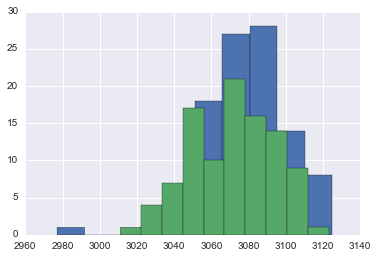

In [401]:
# display two bootstraps
#control_bootstrap.head()
#treatment_bootstrap.head()
plt.hist(control_bootstrap['ts_reply_at_first'])
plt.hist(treatment_bootstrap['ts_reply_at_first'])

# I'm missing a step here, but what
# With this many tests, an effect size of ____ would have been detected ___ percent of the time
# but instead we have the following. 

In [ ]:
# Done

In [ ]:
# Bootstrap these results
# Also use other tests? Look at Fischer exact and wilcoxan. Other than that. Hah, now I need it!
# tsplot
# look at small message groups?
# also watch video
# brainstorm other questions?
# power / effect?


# Fischer exact test
# convergence calcs?
# plotting by month will be tough. Maybe a shitty tsplot will be okay. 
# writeup



# Bootstrap
# group up data to make unique
# make sample, and sample means

# spend time making sure you really know what's going on with all the statistics (chi, fisher, bootstrap)

# make sample
# count # interaction, reply, accepted, booking



In [ ]:
# significant overlap...but how much overlap?

(array([  1.,  10.,  17.,  23.,  32.,  11.,   4.,   1.,   0.,   1.]),
 array([ 461. ,  473.4,  485.8,  498.2,  510.6,  523. ,  535.4,  547.8,
         560.2,  572.6,  585. ]),
 <a list of 10 Patch objects>)

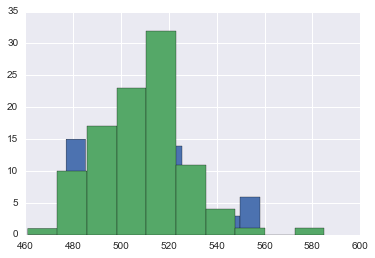

In [356]:
plt.hist(control_stats['ts_booking_at'])
plt.hist(treatment_stats['ts_booking_at'])

In [294]:
contact_data.groupby('id_guest').agg({'id_listing':'count'})['id_listing'].value_counts()

1    6613
2     295
3      25
4       3
Name: id_listing, dtype: int64

In [297]:
# Did guests reach out to fewer listings?

# Were responses faster?

#display(contact_data[control_idx].groupby('id_guest').agg({'id_listing':'count'}).describe())
#display(contact_data[treatment_idx].groupby('id_guest').agg({'id_listing':'count'}).describe())

display(contact_data[control_idx].groupby('id_guest').agg({'id_listing':'count'})['id_listing'].value_counts())
display(contact_data[treatment_idx].groupby('id_guest').agg({'id_listing':'count'})['id_listing'].value_counts())

1    3303
2     157
3       9
4       1
Name: id_listing, dtype: int64

1    3310
2     138
3      16
4       2
Name: id_listing, dtype: int64

In [ ]:
# time of day stuff

In [ ]:
# conclusions

Not much happened, but there are some indications 
that the experiment was not run totally correctly?

In [ ]:
unique_guests.loc[[1,2,1], :]
np.random.choice(contact_data.index, (2, len(contact_data.index)))
#contact_data.groupby(None).agg({'ts_interaction_first':'count'})